# ROB2004 Final Project - pick and place objects

The goal of this project is to solve a simple manipulation task: picking up objects and moving them in a bowl.

## Instructions
* Answer all questions in the notebook
* You will need to submit on Brightspace: 
    1. the code you wrote to answer the questions in a Jupyter Notebook. The code should be runnable as is.
    2. a 2-3 pages report in pdf format (pdf only) detailing the methodology you followed to answer the questions as well as answers to the questions that require a typeset answer. You may add the plots in the report (does not count for the page limit) or in the Jupyter notebook.
* This is an individual project

We will use a model of the Frank-Emika Panda robot. This robot has 7 revolute joints and its kinematics is described in the picture below.

You will need to install pybullet on your computer. Please reach out as soon as possible for help if you do not know how to do it.

<div>
<img src="./panda.jpg" width="200"/>
</div>

# Question

Implement a controller using the code skeletong below in order to get the robot to go and pick up the red blocks and drop them in the green bowl. The bowl position is $(-0.3,0.55,0.65)$ (in spatial frame coordinates) and the blocks positions are $(0.35,0.58,0.65)$ and $(0.15,0.67,0.65)$ respectively.

<div>
<img src="./manipulation_scene.jpg" width="300"/>
</div>

You are free to use the methods that you want to solve the task, with the following constraints:
* You cannot use any external library apart from numpy and scipy
* You need to use at least one controller in the end-effector space
* You need to generate smooth motions
* You need to compensate for the gravity of the robot

In your report, describe the controller and justify your choices. Analyze the behavior of the system (include plots of the end-effector trajectories, velocities, joint trajectories, etc as you see fit).

In [1]:
import numpy as np
import time

import matplotlib.pyplot as plt

from panda import Simulator, PandaRobot

np.set_printoptions(precision=4, suppress = True)

pybullet build time: Aug 21 2022 18:46:39


# Code Skeleton for the simulation

Feel free to change the `run_time` variable to match your needs. The class `Simulator` contains all the code for the simulation. The code skeleton currently implement a simple PD controller in joint space that just keeps a desired current position.

Importantly you can control both the joints and the gripper of the robot:
* `simulator.send_joint_torque(joint_torques)` sends a vector of dimension 7 setting the torques of the joints
* `simulator.gripper_move(gripper_position)` sends a vector of dimension 2 setting the position of the fingers of the gripper. The fingers can have positions from 0 to 0.04cm (you can fully close the gripper by setting `simulator.gripper_move([0,0])` and fully open it by setting `simulator.gripper_move([0.04,0.04)`)

In [2]:
def compute_trajectory(position_init, position_goal, t_init, t_goal, t):
    ''' Parameter can be angle or coordinates, 5th order'''
    T = t_goal - t_init
    dt = t - t_init
    dpos = position_goal - position_init
    pos_param = 10 * (dt / T) ** 3 - 15 * (dt / T) ** 4 + 6 * (dt / T) ** 5
    vel_param = (30 * (dt / T) ** 2 - 60 * (dt / T) ** 3 + 30 * (dt / T) ** 4) / T
    desired_position = position_init + pos_param * dpos
    desired_velocity = vel_param * dpos
    
    # we return the answer
    return desired_position, desired_velocity

In [3]:
# here we create a simulation and reset the state of the robot
simulator = Simulator()
initial_q = np.array([0.,0,0.0,-np.pi/2.,0.,np.pi/2.,np.pi/4])
simulator.reset_state(initial_q)

# we create a robot object so we can use its helper functions
my_robot = PandaRobot()

# duration of the simulation
run_time = 18

# the time to reach a goal
time_to_goal = 2

# simulation time step
dt = 0.005
num_steps = int(run_time/dt)


# we store information
ndofs = 7 # number of degrees of freedom (excluding the gripper)
measured_joint_pos = np.zeros([num_steps,ndofs])
measured_joint_vel = np.zeros_like(measured_joint_pos)
desired_torques = np.zeros_like(measured_joint_pos)
desired_joint_pos = np.zeros_like(measured_joint_pos)
desired_joint_vel = np.zeros_like(measured_joint_pos)
time = np.zeros([num_steps])

'''Record EE Coord'''
measured_ee_pos = np.zeros([num_steps,3])
measured_ee_vel = np.zeros_like(measured_ee_pos)
desired_ee_pos = np.zeros_like(measured_ee_pos)
desired_ee_vel = np.zeros_like(measured_ee_pos)

origin = my_robot.FK(initial_q)[0:3,3]

block1up = np.array([0.35,0.58,0.5])
block1down = np.array([0.35,0.58,0.3])
block2up = np.array([0.15,0.67,0.5])
block2down = np.array([0.15,0.67,0.3])
bowlup = np.array([-0.3,0.55,0.5])

goals = [origin, block1up, block1down, block1up, bowlup, block2up, block2down, block2up, bowlup, origin]
gripper_close = [2,3,6,7]

In [4]:
### this is the main control loop
for i in range(num_steps):
    # get the current time and save it
    time[i] = dt * i
    
    # we get the position and velocities of the joints
    q, dq = simulator.get_state()
    measured_joint_pos[i,:] = q
    measured_joint_vel[i,:] = dq
    pose = my_robot.FK(q)
    measured_ee_pos[i,:] = pose[0:3,3]
    if i > 0: # Get rid of first iter
        measured_ee_vel[i,:] = (measured_ee_pos[i,:] - measured_ee_pos[i-1,:])/dt
    
    ## controller: TODO HERE IMPLEMENT YOUR CONTROLLER TO SOLVE THE TASK
    ## you will need to replace the naive PD controller implemented below

    cur_path = int(time[i] // time_to_goal)
    t_init = cur_path * time_to_goal
    t_goal = (cur_path + 1) * time_to_goal
    
    start_coord = goals[cur_path]
    end_coord = goals[cur_path+1]
    
    x_ref, dx_ref = compute_trajectory(start_coord, end_coord, t_init, t_goal, time[i])
    
    # Record desired data
    desired_ee_pos[i, :] = x_ref
    desired_ee_vel[i, :] = dx_ref
    
    if cur_path in gripper_close:
        gripper_position = [0,0]
    else:
        gripper_position = [0.04, 0.04]
        
    # desired joint positions and velocities
    q_des = np.array([0,0,0.0,0,0.0,q[1] - q[3],q[0]+np.pi/4])
    dq_des = np.zeros([7])
    
    # we save the desired positions/velocities for later plotting 
    desired_joint_pos[i,:] = q_des
    desired_joint_vel[i,:] = dq_des
    
    ##PD controller
    # the PD gains
#     P = np.array([100., 100., 100., 100., 100., 100., 50.])
#     D = np.array([10.,10,10,10,10,10,1.])
    P = 100
    D = 10

    error = q_des - q # the position error for all the joints
    d_error = dq_des-dq # the velocity error for all the joints
    
    K = np.array([300,300,300])
    B = np.array([30,30,30])
    jacob = my_robot.get_jacobian(q, 'O')[3:,:]
    # we compute the desired torques as a PD controller
#     if i > 1000:
    joint_torques = jacob.T @ (np.diag(K) @ (x_ref - measured_ee_pos[i,:]) + np.diag(B) @ (dx_ref - measured_ee_vel[i,:]))
    fix_joints = [2,4,5,6]
    joint_torques[fix_joints] = 100 * error[fix_joints] + 10 * d_error[fix_joints]
    
    joint_torques += my_robot.g(q)
# joint 5 must be vertical
# joint 6 must be parallel to edge


    if i % 100 == 0:
        print(np.rad2deg(q[1]), 
              np.rad2deg(q[3]),
              np.rad2deg(q[5]))

    
    
    # we send them to the robot and do one simulation step
    simulator.send_joint_torque(joint_torques)
    simulator.gripper_move(gripper_position)
    simulator.step()

0.0 -90.0 90.0
0.9625757282420084 -89.79986468296168 90.33272280680775
4.051327938299214 -93.4977006928054 95.82611625930589
17.395829070841145 -84.24809735371976 101.27474928383221
26.00021617808333 -73.25953006996893 99.90913054287446
23.475697789418493 -77.48866177436669 100.06378521935348
24.161693522941576 -88.61627387730049 109.82188476498229
29.58355634826065 -94.15114968923119 121.83682311070123
31.17865564957479 -94.79546202234926 126.05403079152894
29.295649858948632 -95.6697496357156 125.14256838030471
24.343497558396496 -91.59542274377131 118.44612178253331
19.980911454924538 -84.02228727747492 106.17874172624686
21.822707670136065 -78.57727973105587 100.54490759846811
20.988178502768967 -80.99767735143044 101.4506799002615
3.389345845635538 -104.9785415457689 106.84573353316189
1.5255271565611588 -105.68307512116992 107.99769819420695
15.84647339199211 -88.96244150930464 105.04420749813366
12.610326670975034 -92.07080633873015 104.63089263412523
6.975857119095087 -99.23906

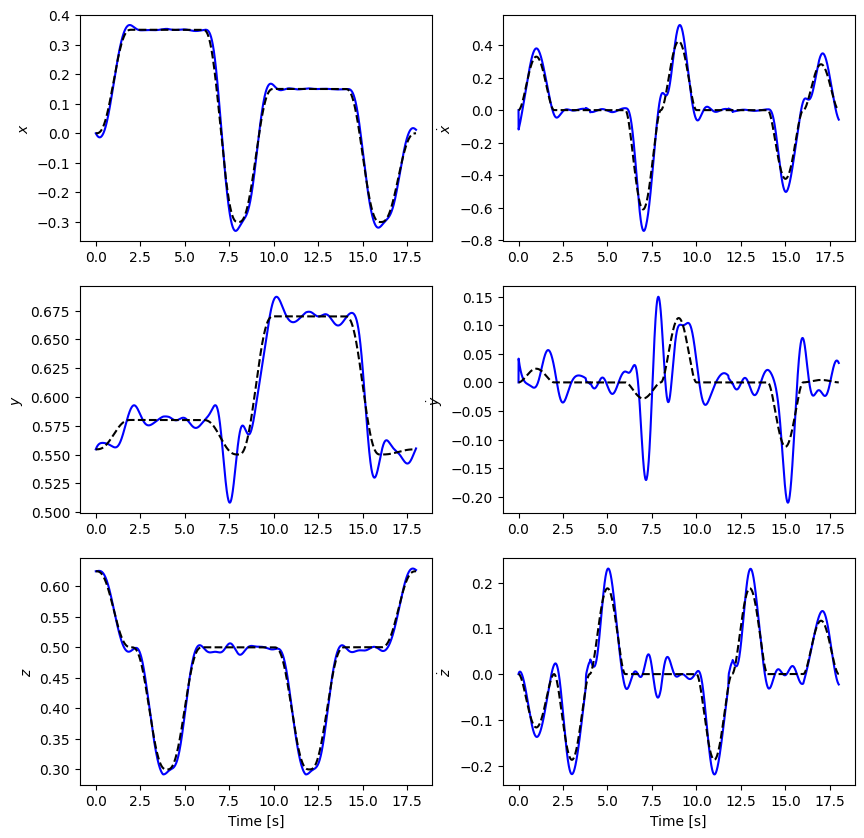

In [5]:
def plot_ee_posvel(time, th, th_des, dth, dth_des):
    fig = plt.figure(figsize=(10,10))
    
    plt.subplot(3,2,1)
    plt.plot(time, th[:,0], 'b-', time, th_des[:,0], '--k')
    plt.ylabel(r'$x$')
    plt.subplot(3,2,3)
    plt.plot(time, th[:,1], 'b-', time, th_des[:,1], '--k')
    plt.ylabel(r'$y$')
    plt.subplot(3,2,5)
    plt.plot(time, th[:,2], 'b-', time, th_des[:,2], '--k')
    plt.ylabel(r'$z$')
    plt.xlabel('Time [s]')
    
    plt.subplot(3,2,2)
    plt.plot(time, dth[:,0], 'b-', time, dth_des[:,0], '--k')
    plt.ylabel(r'$\dot{x}$')
    plt.subplot(3,2,4)
    plt.plot(time, dth[:,1], 'b-', time, dth_des[:,1], '--k')
    plt.ylabel(r'$\dot{y}$')
    plt.subplot(3,2,6)
    plt.plot(time, dth[:,2], 'b-', time, dth_des[:,2], '--k')
    plt.ylabel(r'$\dot{z}$')
    plt.xlabel('Time [s]')
    
plot_ee_posvel(time, measured_ee_pos, desired_ee_pos, measured_ee_vel, desired_ee_vel)

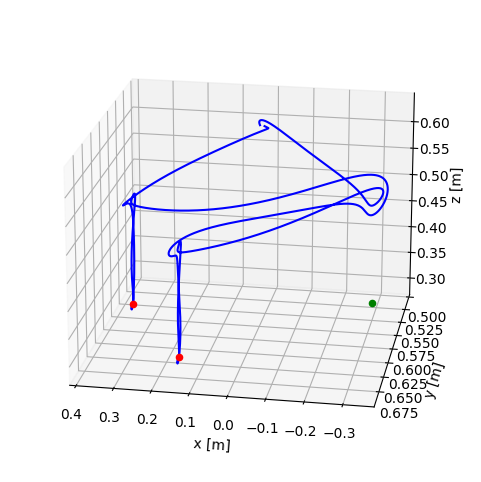

In [8]:
def plot_finger_trajectory(finger_position):
    """
    plots the position of the finger in 2D and the position of the spatial frame {s}
    we assume that the time varying x variable is in x_pos and that the y variable is in y_pos
    """
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111,projection='3d')
    ax.scatter(0.35,0.58,0.3, color='red')
    ax.scatter(0.15,0.67,0.3, color='red')
    ax.scatter(-0.3,0.55,0.3, color='green')
    

    plt.plot(finger_position[:,0],finger_position[:,1],finger_position[:,2], 'b')
    ax.set_xlabel('x [m]')
    ax.set_ylabel('y [m]')
    ax.set_zlabel('z [m]')
    ax.view_init(elev=20, azim=100)

#     plt.xlim([-l1-l2+l0-0.05,l0+l1+l2+0.05])
#     plt.ylim([-l1-l2-0.05, l1+l2+0.05])
#     plt.plot([0],[0],[0],'o',markersize=15,color='r')
    
#     ax.annotate('Spatial frame {s}', xy=(-0.03,-0.005), xytext=(30,0), textcoords='offset points')
    

plot_finger_trajectory(measured_ee_pos)

# Helper functions

We provide a set of helper functions (forward kinematics, Jacobians, gravity terms) that can be used to implement the desired controllers. These functions are implemented in the PandaRobot class (in the panda.py file).
Examples are shown below: